In [2]:
from fastai.vision.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import gc

In [3]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.
torch.cuda.set_device('cuda:1')
random_seed(3407,True)

In [4]:
train_df = pd.read_csv('./dataset/output.csv')
train_df['Filename'] = train_df['Filename'].apply(lambda x : "dataset/" + x)
train_df

#train_df = pd.read_csv('pesudo_labelV3.csv')

,Filename,Class
0,dataset/Train/Train/Style2/2188.jpeg,2
1,dataset/Train/Train/Style2/2567.jpeg,2
2,dataset/Train/Train/Style2/2213.jpeg,2
3,dataset/Train/Train/Style2/2470.jpeg,2
4,dataset/Train/Train/Style2/2701.jpeg,2
...,...,...
3023,dataset/Train/Train/Style3/3524.jpeg,3
3024,dataset/Train/Train/Style3/3207.jpeg,3
3025,dataset/Train/Train/Style3/3021.jpeg,3
3026,dataset/Train/Train/Style3/3456.jpeg,3


In [5]:
strat_kfold = MultilabelStratifiedKFold(n_splits=10, random_state=42, shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.Filename.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
train_df.head()

,Filename,Class,fold
0,dataset/Train/Train/Style2/2188.jpeg,2,1
1,dataset/Train/Train/Style2/2567.jpeg,2,9
2,dataset/Train/Train/Style2/2213.jpeg,2,0
3,dataset/Train/Train/Style2/2470.jpeg,2,3
4,dataset/Train/Train/Style2/2701.jpeg,2,5


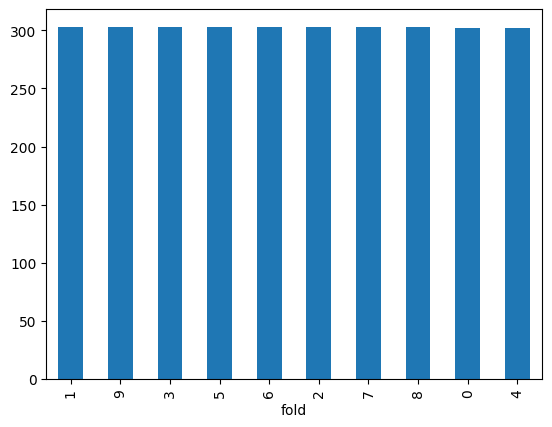

In [6]:
train_df.fold.value_counts().plot.bar();

In [7]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    


In [8]:
import albumentations
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')
size = 448
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            #AutoContrast(),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-360, 360)),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            #albumentations.Sharpen(always_apply=False, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            #albumentations.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=(0.0, 0)),
            #albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-20, 20), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
            # albumentations.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            # #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            # albumentations.RandomBrightnessContrast(
            #     brightness_limit=(-0.2,0.2), 
            #     contrast_limit=(-0.2, 0.2), 
            #     p=0.5
            # ),
            #albumentations.RandomGamma(),
            #albumentations.ToGray(always_apply=False, p=1.0)
            
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [9]:
def get_data(fold=0):
    return DataBlock(blocks=(ImageBlock,CategoryBlock),
                       get_x=ColReader(0),
                       get_y=ColReader(1),
                       splitter=IndexSplitter(train_df[train_df.fold == fold].index),
                       item_tfms=item_tfms,
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                      ).dataloaders(train_df, bs=8)

In [10]:
test_df = pd.read_csv('dataset/test.csv')
test_df['id'] = test_df['id'].apply(lambda x : "dataset/Test/Test/" + x + ".jpeg")
tstpng = test_df.copy()
tstpng.head()

,id,label
0,dataset/Test/Test/wpQ2dWy8zBU.jpeg,NaN
1,dataset/Test/Test/_L7UOm7FhyY.jpeg,NaN
2,dataset/Test/Test/_NqbCub1L8I.jpeg,NaN
3,dataset/Test/Test/36u_FGbUVi0.jpeg,NaN
4,dataset/Test/Test/OUMN2up4ZXI.jpeg,NaN


In [11]:
all_preds = []
cutmix = CutMix(1.)
for i in range(10):
    dls = get_data(i)
    
    learn = cnn_learner(dls, 'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k',metrics=accuracy,cbs= [SaveModelCallback(monitor='valid_loss'),
                                                                                                                cutmix]).to_fp16()
    #learn.fit_one_cycle(10, slice(1e-5,1e-4))
    learn.fine_tune(5)

    
    
    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,1.277097,0.347616,0.877483,02:48


Better model found at epoch 0 with valid_loss value: 0.34761592745780945.


epoch,train_loss,valid_loss,accuracy,time
0,0.909389,0.259933,0.913907,03:38
1,0.840781,0.116194,0.980132,03:38
2,0.650549,0.117117,0.993378,03:38
3,0.563432,0.047854,1.000000,03:38
4,0.505854,0.048428,1.000000,03:38


Better model found at epoch 0 with valid_loss value: 0.2599330544471741.
Better model found at epoch 1 with valid_loss value: 0.11619388312101364.
Better model found at epoch 3 with valid_loss value: 0.04785384237766266.


epoch,train_loss,valid_loss,accuracy,time
0,1.333104,0.413202,0.864686,02:51


Better model found at epoch 0 with valid_loss value: 0.4132022261619568.


epoch,train_loss,valid_loss,accuracy,time
0,0.976281,0.184551,0.953795,03:39
1,0.777306,0.120867,0.993399,03:38
2,0.650473,0.084023,0.996700,03:38
3,0.562437,0.056041,1.000000,03:38
4,0.555859,0.034239,1.000000,03:36


Better model found at epoch 0 with valid_loss value: 0.18455128371715546.
Better model found at epoch 1 with valid_loss value: 0.12086746096611023.
Better model found at epoch 2 with valid_loss value: 0.0840233564376831.
Better model found at epoch 3 with valid_loss value: 0.05604147911071777.
Better model found at epoch 4 with valid_loss value: 0.03423942252993584.


epoch,train_loss,valid_loss,accuracy,time
0,1.268050,0.353206,0.881188,02:48


Better model found at epoch 0 with valid_loss value: 0.3532061278820038.


epoch,train_loss,valid_loss,accuracy,time
0,1.013365,0.258946,0.907591,03:34
1,0.838893,0.120218,0.986799,03:33
2,0.636824,0.071320,0.990099,03:33
3,0.541572,0.068442,0.996700,03:32
4,0.515223,0.040281,1.000000,03:32


Better model found at epoch 0 with valid_loss value: 0.25894567370414734.
Better model found at epoch 1 with valid_loss value: 0.12021841108798981.
Better model found at epoch 2 with valid_loss value: 0.07132009416818619.
Better model found at epoch 3 with valid_loss value: 0.06844193488359451.
Better model found at epoch 4 with valid_loss value: 0.040280696004629135.


epoch,train_loss,valid_loss,accuracy,time
0,1.247300,0.261018,0.907591,02:46


Better model found at epoch 0 with valid_loss value: 0.26101845502853394.


epoch,train_loss,valid_loss,accuracy,time
0,1.013013,0.206407,0.917492,03:31
1,0.721666,0.255940,0.914191,03:31
2,0.595481,0.056692,0.993399,03:31
3,0.534630,0.048109,1.000000,03:31
4,0.526777,0.041146,1.000000,03:31


Better model found at epoch 0 with valid_loss value: 0.20640739798545837.
Better model found at epoch 2 with valid_loss value: 0.056691501289606094.
Better model found at epoch 3 with valid_loss value: 0.04810928553342819.
Better model found at epoch 4 with valid_loss value: 0.041146352887153625.


epoch,train_loss,valid_loss,accuracy,time
0,1.339828,0.195925,0.930464,02:45


Better model found at epoch 0 with valid_loss value: 0.19592469930648804.


epoch,train_loss,valid_loss,accuracy,time
0,1.113390,0.582263,0.798013,03:31
1,0.821951,0.151204,0.980132,03:31
2,0.640105,0.034084,1.000000,03:33
3,0.548853,0.033471,1.000000,03:33
4,0.560873,0.025671,1.000000,03:32


Better model found at epoch 0 with valid_loss value: 0.5822632312774658.
Better model found at epoch 1 with valid_loss value: 0.15120361745357513.
Better model found at epoch 2 with valid_loss value: 0.03408360853791237.
Better model found at epoch 3 with valid_loss value: 0.033471427857875824.
Better model found at epoch 4 with valid_loss value: 0.025670867413282394.


epoch,train_loss,valid_loss,accuracy,time
0,1.347362,0.364780,0.848185,02:46


Better model found at epoch 0 with valid_loss value: 0.3647797703742981.


epoch,train_loss,valid_loss,accuracy,time
0,1.001158,0.438351,0.841584,03:32
1,0.753118,0.195566,0.950495,03:33
2,0.658972,0.106745,0.976898,03:33
3,0.576347,0.047287,1.000000,03:35
4,0.531951,0.035477,1.000000,03:36


Better model found at epoch 0 with valid_loss value: 0.43835097551345825.
Better model found at epoch 1 with valid_loss value: 0.1955663114786148.
Better model found at epoch 2 with valid_loss value: 0.10674510151147842.
Better model found at epoch 3 with valid_loss value: 0.04728659242391586.
Better model found at epoch 4 with valid_loss value: 0.03547748550772667.


epoch,train_loss,valid_loss,accuracy,time
0,1.294760,0.284235,0.897690,02:49


Better model found at epoch 0 with valid_loss value: 0.28423529863357544.


epoch,train_loss,valid_loss,accuracy,time
0,1.051557,0.337701,0.907591,03:37
1,0.780053,0.098996,0.990099,03:38
2,0.640206,0.054394,1.000000,03:38
3,0.542252,0.040480,1.000000,03:38
4,0.531682,0.043329,1.000000,03:38


Better model found at epoch 0 with valid_loss value: 0.3377014100551605.
Better model found at epoch 1 with valid_loss value: 0.09899552911520004.
Better model found at epoch 2 with valid_loss value: 0.05439445376396179.
Better model found at epoch 3 with valid_loss value: 0.040480028837919235.


epoch,train_loss,valid_loss,accuracy,time
0,1.296033,0.371649,0.854786,02:51


Better model found at epoch 0 with valid_loss value: 0.3716486394405365.


epoch,train_loss,valid_loss,accuracy,time
0,1.020759,0.153697,0.947195,03:38
1,0.775943,0.137715,0.970297,03:39
2,0.662675,0.092162,0.996700,03:38
3,0.565869,0.041521,1.000000,03:38
4,0.505478,0.036235,1.000000,03:38


Better model found at epoch 0 with valid_loss value: 0.1536971777677536.
Better model found at epoch 1 with valid_loss value: 0.1377147138118744.
Better model found at epoch 2 with valid_loss value: 0.09216183423995972.
Better model found at epoch 3 with valid_loss value: 0.041521307080984116.
Better model found at epoch 4 with valid_loss value: 0.03623466193675995.


epoch,train_loss,valid_loss,accuracy,time
0,1.214314,0.276657,0.910891,02:51


Better model found at epoch 0 with valid_loss value: 0.27665650844573975.


epoch,train_loss,valid_loss,accuracy,time
0,0.951884,0.193688,0.960396,03:39
1,0.787755,0.082185,0.993399,03:39
2,0.619582,0.070141,1.000000,03:39
3,0.562454,0.037495,1.000000,03:39


Better model found at epoch 0 with valid_loss value: 0.19368843734264374.
Better model found at epoch 1 with valid_loss value: 0.0821848213672638.
Better model found at epoch 2 with valid_loss value: 0.07014058530330658.
Better model found at epoch 3 with valid_loss value: 0.037494540214538574.
Better model found at epoch 0 with valid_loss value: 0.22548818588256836.


epoch,train_loss,valid_loss,accuracy,time
0,1.011792,0.280688,0.884488,03:39
1,0.821732,0.103125,0.990099,03:39
2,0.630885,0.063704,1.000000,03:39
3,0.589646,0.045135,1.000000,03:39
4,0.525813,0.038017,1.000000,03:39


Better model found at epoch 0 with valid_loss value: 0.2806878983974457.
Better model found at epoch 1 with valid_loss value: 0.10312454402446747.
Better model found at epoch 2 with valid_loss value: 0.06370420753955841.
Better model found at epoch 3 with valid_loss value: 0.04513482004404068.
Better model found at epoch 4 with valid_loss value: 0.03801744058728218.


In [12]:
sub = pd.read_csv('dataset/test.csv')
preds = np.mean(np.stack(all_preds), axis=0)
preds = torch.from_numpy(preds)

In [13]:
#tta_preds, _ = tta
idxs = preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv('dataset/test.csv')
sub['label'] = vocab[idxs]


In [14]:
sub.to_csv("EVA02_cutmix10FOLDREAL.csv",index=False)